# Stima dell'efficacia di un vaccino

La stima dell'efficacia di un vaccino è argomento di grande attualità. Il 30/12/2020 è stata pubblicata l'analisi dell'efficacia del vaccino della Pfitzer contro il Sars-Cov-2 in [N Engl J Med 2020; 383:2603-2615](https://www.nejm.org/doi/full/10.1056/NEJMoa2034577). Il 2/2/2021 è stata pubblicata l'analisi dell'efficacia del vaccino Sputnik V in [Lancet 2021; 397: 671–81](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(21)00234-8/fulltext)

Nel seguito vediamo un metodo semplificato ma corretto per la determinazione dell'efficacia da un capione di persone vaccinate ed un campione di persone che hanno ricevuto un placebo.



In [1]:
import math
import numpy as np
import pandas as pd
import scipy.optimize
from scipy.stats import binom
from scipy.stats import norm
import statsmodels
import statsmodels.stats.proportion as proportion
import matplotlib.pyplot as plt

## Tasso di contagio in assenza di vaccino

Se sappiamo di avere in Italia circa $15\,000$ infettti al giorni su 60 milioni di abitanti, circa, possiamo calcolare la **probabilità di infettersi in $n$ giorni per una persona non vaccinata**, come:

$p_0 = 1-(1-p_{0,1\mathrm{g}})^n \simeq n\cdot p_{0,1\mathrm{g}}$ se $p_{0,1\mathrm{g}}\ll 1$. 

dove $p_{0,1\mathrm{g}}$ è la probabilità di infettarsi in un giorno per una persona che non si è vaccianta.

In [3]:
n0, n1 = 10000, 10000
# Italia, 15.000 casi su 60M al giorno
p1g = 15000/60000000
ng = 30
p0 = 1 - math.pow(1-p1g, ng)
print('p(1g): {:.4%}'.format(p1g))
print('p0: {:.4%}'.format(p0))

p(1g): 0.0250%
p0: 0.7473%


Assumendo un'efficacia $\varepsilon$, ossia, possiamo calcolare la **probabilità di infettarsi entro $n$ giorni per un vaccinato** come:

$p_1 = p_0\,(1-\varepsilon)$

In [4]:
eff = 0.9
p1 = p0*(1-eff)

## Campioni di test e di controllo

Supponiamo di avere $N_0$ persone non vaccinate (es.: vaccinate con un *placebo*) e $N_1$ persone vaccinate. 

Si può calcolare quanti casi di infezioni $I_1$ e $I_0$ ci si aspetta tra vaccinati e tra non vaccinati nel periodo di osservazione di $n$ giorni:

$\mathbb{E}[{I_0}] = p_0\, N_0$

$\mathbb{E}[{I_1}] = p_1\, N_1 = p_0\,(1-\varepsilon) N_1$

In [5]:
i0_exp = p0*n0
i1_exp = p1*n1
print('Expected no vax: E[i0]={:.3f}'.format(i0_exp))
print('Expected vax   : E[i1]={:.3f}'.format(i1_exp))

Expected no vax: E[i0]=74.729
Expected vax   : E[i1]=7.473


La distribuzione del numero di casi osservati nelle due categorie seguirà una distribuzione biomiale con valori attesi indicati sopra.

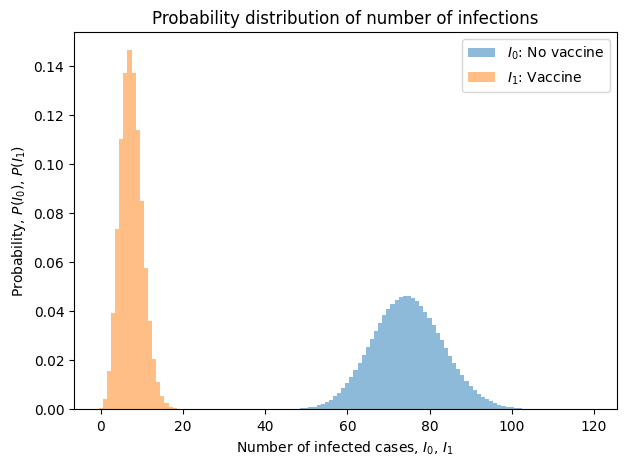

In [6]:
i_range = np.arange(0,120)
pdf0 = binom.pmf(i_range,n0,p0)
pdf1 = binom.pmf(i_range,n0,p1)
plt.figure(figsize=(7,5), dpi=100)
plt.bar(i_range, pdf0, width=1, label='$I_0$: No vaccine', alpha=0.5)
plt.bar(i_range, pdf1, width=1, label='$I_1$: Vaccine', alpha=0.5)
plt.title("Probability distribution of number of infections")
plt.xlabel("Number of infected cases, $I_0$, $I_1$")
plt.ylabel("Probability, $P(I_0)$, $P(I_1)$")
plt.legend()
plt.show()

Definiamo la funzione di verosimiglianza dell'osservazione simultanea del numero di infetti osservati nei due campioni, $I_0$ e $I_1$, come il prodotto di due binomiali con probabilità che dipendono dal valore di efficienza che viene assunto.

Supponiamo di avere un certo numero di casi osservati, $I_0$ e $I_1$.

In [7]:
# test values
i0, i1 = 75, 11

## Stima dei parametri incogniti

Possiamo stimare, e si può dimostrare analiticamente che corrisponde alla stima di massima verosimiglianza:
    
$\displaystyle \widehat{p_0} = r_0 = \frac{I_0}{N_0}$

$\displaystyle \widehat{p_1} = \widehat{p_0}(1-\widehat{\varepsilon}) =  r_1 = \frac{I_1}{N_1}$

Da cui:

$\displaystyle \widehat{\varepsilon} = 1 - \frac{\widehat{p_1}}{\widehat{p_0}}$

La tima di $p$ con il campione di controllo di non vaccinati è molto più precisa di quanto più essere una determinazione a partire dal numero di contagi nazionali, perché il campione vaccinato non è necessariamente rappresentativo dell'intera popolazione.

Da notare che, mentre $I_0$ e $I_1$ sono indipendenti, c'è necessariamente correlazione tra le stime $\widehat{p_0}$ e $\widehat{\varepsilon}$ perché c'è una relazione che lega un parametro all'altro.

Il rapporto $\widehat{p_1}/\widehat{p_0}$ viene detto [*risk ratio*](https://sphweb.bumc.bu.edu/otlt/MPH-modules/EP/EP713_Association/EP713_Association3.html).

In [8]:
p0_est, p1_est = i0/n0, i1/n1
eff_est = 1.0 - p1_est/p0_est
print('** Summary **')
print ('novax: N0=', n0, 'I0=', i0, 'p0={:.5f}'.format(p0))
print ('vax  : N1=', n1, 'I1=', i1, 'p1={:.5f}'.format(p1))
print('efficacy: ε(est)={:.5f}'.format(eff_est))

** Summary **
novax: N0= 10000 I0= 75 p0=0.00747
vax  : N1= 10000 I1= 11 p1=0.00075
efficacy: ε(est)=0.85333


## Stima delle incertezze

Si potrebbe stimare l'incerezza su $\widehat{p}$ e $\widehat{p}(1-\widehat{\varepsilon})$ con un'approssimazione gaussiana delle incertezze binomiali:

$\displaystyle \sigma_{\widehat{p_0}} = \sqrt{\frac{\widehat{p_0}(1-\widehat{p_0})}{N_0}}$

$\displaystyle \sigma_{\widehat{p_1}} = \sqrt{\frac{\widehat{p_1}(1-\widehat{p_1})}{N_1}}$


Tuttavia, preferiamo stabilire un metodo non approssimato perché può essere valido anche quando il numero $I_1$ è molto piccolo. Considerando che l'efficienza di un vaccino può essere molto alta, è possibile che $I_1$ sia molto piccolo.

In [9]:
p0_err = math.sqrt(p0_est*(1-p0_est)/n0)
print("p0 = {:.5f} ± {:.5f}".format(p0, p0_err))

p0 = 0.00747 ± 0.00086


In [10]:
p1_err = math.sqrt(p1_est*(1-p1_est)/n1)
print("p1 = {:.5f} ± {:.5f}".format(p1, p1_err))

p1 = 0.00075 ± 0.00033


La propagazione degli errori su $\widehat{p}^\star/\widehat{p}$ richiede la somma in quadratura degli errori relativi.

In [11]:
eff_err = (1-eff_est)*math.sqrt((p0_err/p0_est)**2+(p1_err/p1_est)**2)
print("ε = {:.3f} ± {:.3f}".format(eff_est, eff_err))

ε = 0.853 ± 0.047


## Stima di massima verosimiglianza

Possiamo definire la funzione di verosimiglianza come prodotto di due PDF binomiali, una per ciascun campione. 

La funzione di verosimiglianza dipenderà da:
* I valori osservati $I_0$, $I_1$
* l'efficacia del vaccino $\varepsilon$
* la probabilità di infezione senza vaccino $p_0$
* il numero di persone non vaccinate e vaccinate, $N_0$ e $N_1$

${\cal L} = p(I_0, I_1; \varepsilon, p, N_0, N_1) = p(I_0; p_0, N_0)\cdot p(I_1; (1-\varepsilon)\,p_0, N_1)$

In [12]:
def likelihood(i0, i1, eff, p0, n0, n1):
    pdf0 = binom.pmf(i0, n0, p0)
    p1 = p0*max(0.0001, 1-eff)
    pdf1 = binom.pmf(i1, n1, p1)
    lik = pdf0 * pdf1
    return lik

Definiamo una funzione che restituisca $-2\log{\cal L}$ che va minimizzata:

In [13]:
def neg_2log_likelihood(i0, i1, eff, p0, n0, n1):
    return -2*math.log(likelihood(i0, i1, eff, p0, n0, n1))

Definiamo una funzione che calcola il valore minimo a partire da una coppia di valori inziali ```init```:

In [15]:
def max_likelihood(i0, i1, n0, n1, init):
    xopt, fopt, niter, funcalls, warnflag = scipy.optimize.fmin(lambda args:
        neg_2log_likelihood(i0, i1, args[0], args[1], n0, n1), init,
        full_output=True, disp=False)
    return xopt, fopt

Partiamo da valori vicini alla stima finale

In [16]:
lik_init = [0.85, 0.001]
max_val, f_min = max_likelihood(i0, i1, n0, n1, lik_init)

In [17]:
eff_ml, p0_ml = max_val[0], max_val[1]
p1_ml = p0_ml*(1-eff_ml)

In [18]:
print('** Summary **')
print('-2lnL min: {:.5f}'.format(f_min))
print ('novax: N0=', n0, 'I0=', i0, 'p0={:.5f}'.format(p0))
print ('vax  : N1=', n1, 'I1=', i1, 'p1={:.5f}'.format(p1))
print('efficacy: ε(est)={:.5f}, ε(m.l.)={:.5f}'.format(eff_est, eff_ml))
print('p0: true={:.5f}, est={:.5f}, m.l.={:.5f}'.format(p0, p0_est, p0_ml))
print('p1: true={:.5f}, est={:.5f}, m.l.={:.5f}'.format(p1, p1_est, p1_ml))

** Summary **
-2lnL min: 10.39988
novax: N0= 10000 I0= 75 p0=0.00747
vax  : N1= 10000 I1= 11 p1=0.00075
efficacy: ε(est)=0.85333, ε(m.l.)=0.85332
p0: true=0.00747, est=0.00750, m.l.=0.00750
p1: true=0.00075, est=0.00110, m.l.=0.00110


Calcoliamo l'intervallo che corrisponde ad una variazione di $-2\log{\cal L}$ di +1.

Questo ci fornirà una stima dell'errore migliore di quella con l'approssimazione gaussiana.

In [19]:
def interval_ml():
    if i1 == n1:
        x_lo = 0
    else:
        x_lo = scipy.optimize.root_scalar(lambda x:
            neg_2log_likelihood(i0, i1, x, p0_ml, n0, n1) - f_min - 1, 
            method='bisect', bracket=(0.0, eff_ml), xtol=0.00000001).root
    if i1 == 0:
        x_hi = 1
    else:
        x_hi = scipy.optimize.root_scalar(lambda x:
            neg_2log_likelihood(i0, i1, x, p0_ml, n0, n1) - f_min - 1, 
            method='bisect', bracket=(eff_ml, 0.9999999), xtol=0.00000001).root
    return x_lo, x_hi
int_ml = interval_ml()
print('Int. max. lik.: [{:.5f}, {:.5f}]'.format(int_ml[0], int_ml[1]))
print('eff = {:.5f} +{:.5f}/-{:.5f}'.format(eff_ml, int_ml[1]-eff_ml,eff_ml-int_ml[0]))

Int. max. lik.: [0.80457, 0.89320]
eff = 0.85332 +0.03988/-0.04875


In [20]:
x_range = np.linspace(0.0, 1, 1000)
y = []
for x in x_range:
    y.append(neg_2log_likelihood(i0, i1, x, p0_ml, n0, n1))
y_lik = np.array(y) - f_min
y_range = [0, np.max(y_lik)]

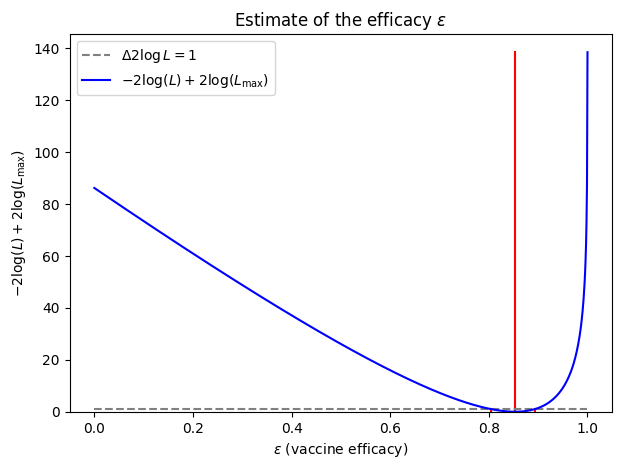

In [21]:
plt.figure(figsize=(7,5), dpi=100)
plt.plot([eff_ml, eff_ml], y_range, color='red')
plt.plot([0, 1], [1, 1], label=r"$\Delta 2\log L = 1$", color='gray', linestyle='--')
plt.plot([int_ml[0],int_ml[0]], [0, 1], color='red')
plt.plot([int_ml[1],int_ml[1]], [0, 1], color='red')
plt.plot(x_range, y_lik, label=r"$-2\log(L) + 2\log(L_{\mathrm{max}})$", color='blue')
plt.title(r"Estimate of the efficacy $\varepsilon$")
plt.xlabel(r"$\varepsilon$ (vaccine efficacy)")
plt.ylabel(r"$-2\log(L) + 2\log (L_{\mathrm{max}})$")
plt.legend()
plt.ylim(0)
plt.show()

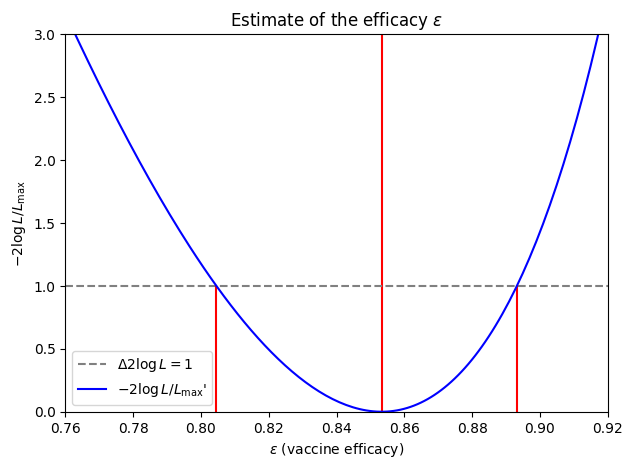

In [22]:
plt.figure(figsize=(7,5), dpi=100)
plt.plot([eff_ml, eff_ml], y_range, color='red')
plt.plot([0, 1], [1, 1], label=r"$\Delta 2\log L = 1$", color='gray', linestyle='--')
plt.plot([int_ml[0],int_ml[0]], [0, 1], color='red')
plt.plot([int_ml[1],int_ml[1]], [0, 1], color='red')
plt.plot(x_range, y_lik, label=r"$-2\log L/L_{\mathrm{max}}$'", color='blue')
plt.title(r"Estimate of the efficacy $\varepsilon$")
plt.xlabel(r"$\varepsilon$ (vaccine efficacy)")
plt.ylabel(r"$-2\log L/L_{\mathrm{max}}$")
plt.legend()
plt.ylim(0,3)
plt.xlim(0.76,0.92)
plt.show()

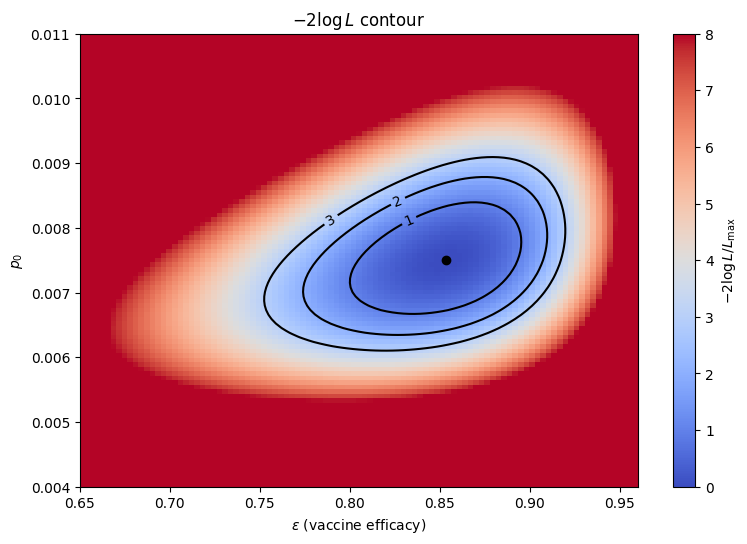

In [23]:
nptx, npty = 101, 101
x_p = np.linspace(0.65, 0.96, nptx)
y_p = np.linspace(0.004, 0.011, npty)
x, y = np.meshgrid(x_p, y_p)
f = lambda eff, p0: np.vectorize(neg_2log_likelihood)(i0, i1, eff, p0, n0, n1) - f_min
z = f(x, y)
figure, ax = plt.subplots(figsize=(9,6), dpi=100)
col = ax.pcolormesh(x, y, z, cmap='coolwarm', vmin=0, vmax=8, shading='auto')
con = ax.contour(x, y, z, np.arange(0, 3.1, 1), colors='black')
ax.scatter([eff_ml], [p0_ml], color='black')
ax.clabel(con, inline=1, fontsize=10)
ax.set_title('$-2\log L$ contour')
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel(r"$\varepsilon$ (vaccine efficacy)")
ax.set_ylabel('$p_0$')
figure.colorbar(col, label='$-2\log L/L_{\mathrm{max}}$')
plt.show()